1D harmonic oscillator physics-informed neural network (PINN)
This notebook contains the code to reproduce the plots presented in the Code of PINNS for harmoinc oscillator by https://github.com/benmoseley/harmonic-oscillator-pinn/blob/main/Harmonic%20oscillator%20PINN.ipynb

This problem was inspired by the following blog post: https://beltoforion.de/en/harmonic_oscillator/.

In [ ]:
# Installing all necessary libraries
!pip install numpy
!pip install torch
!pip install matplotlib
!pip install pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.8 MB/s eta 0:00:00
   ━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/664.8 MB 131.6 MB/s eta 0:00:05
ERROR: Operation cancelled by user
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pytorch)


NumPy handles numerical computations and data generation.
PyTorch is used to build and train the neural network.
Matplotlib helps visualize results, such as predicted motion and loss curves.
PyTorch (again) is redundantly installed, as torch already includes it.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

##STEP1: Building the Neural Network for Simple Harmonic Motion
To model the 1D Simple Harmonic Motion (SHM) using a Physics-Informed Neural Network (PINN), we need a neural network that can learn from the physics of the system. That’s where our Fully Connected Network (FCN) comes in.

At its core, this FCN is a standard feedforward neural network that takes an input (like time t), processes it through multiple layers, and outputs a prediction (such as displacement V(t)). But let’s break it down step by step.

# 1. Defining the Network Architecture
The FCN consists of three main sections:

The input layer (fcs): This is the first layer that receives the input and applies a transformation. It takes N_INPUT neurons and connects them to N_HIDDEN neurons (the hidden layer size). It also applies a Tanh activation function, which helps in capturing smooth variations in motion.
The hidden layers (fch): These layers are where most of the learning happens. Each hidden layer takes the output from the previous layer, applies a transformation, and passes it to the next one. The number of these layers is controlled by N_LAYERS, and each of them uses the Tanh activation function to introduce non-linearity.
The output layer (fce): This final layer takes the last hidden layer’s output and converts it into the final prediction, using N_OUTPUT neurons.
# 2. How Data Flows Through the Network
Once we define the architecture, the forward function tells us how the data moves through the network:

The input goes through the first layer (fcs), where it is transformed using a linear layer and an activation function.
It then passes through a sequence of hidden layers (fch), which refine the representation.
Finally, it reaches the output layer (fce), which produces the final predicted value, like displacement at a given time.
This neural network serves as the backbone of our PINN model, allowing it to learn the motion dynamics while respecting the physical laws governing Simple Harmonic Motion.
The full code is implemented below.



In [2]:


class FCN(nn.Module):
    "Defines a connected network"

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

## STEP2: Modeling an Underdamped Harmonic Oscillator
Now that we’ve defined our neural network (FCN) in the previous step, it’s time to introduce the actual physical system we want to model: a 1D underdamped harmonic oscillator.

A harmonic oscillator describes a system that experiences a restoring force proportional to its displacement. The specific type of oscillation we’re dealing with here is underdamped oscillation, which means that the system oscillates while gradually losing energy over time due to damping.

Why is This Important?
This function provides the true analytical solution for an underdamped harmonic oscillator, which we can use to compare against our Physics-Informed Neural Network (PINN) predictions. By doing so, we can check how well our neural network approximates the actual physics of the system.



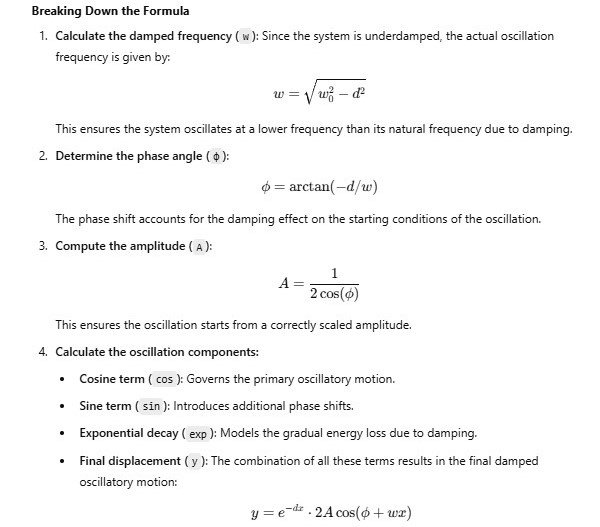

In [3]:
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem.
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y


Step 3: Generating and Visualizing the Training Data
With the analytical solution for our 1D underdamped harmonic oscillator in place, the next step involves generating data that will serve as the foundation for training our Physics-Informed Neural Network (PINN). This is a critical phase, as it establishes the reference behavior of the oscillator and provides the information the model will learn from.

To begin, we define two fundamental parameters that characterize the system: the damping coefficient (d) and the natural frequency (w0). In this case, we set d = 2, which determines how quickly the oscillations decay over time, and w0 = 20, which defines the frequency at which the system would oscillate in the absence of damping. These values ensure that the system exhibits an underdamped motion, where oscillations gradually diminish but remain present for a significant duration.

Once these parameters are defined, we generate the analytical solution across a continuous domain. We create a tensor x that consists of 500 evenly spaced points between 0 and 1, representing discrete time steps over which we evaluate the oscillator’s displacement. By passing x through our previously defined oscillator() function, we compute the corresponding displacement values, stored in y. Since both x and y need to be in the correct shape for subsequent operations, we ensure they are properly structured by reshaping them into column vectors.

Rather than using all 500 points for training, we strategically extract a small subset from the left-hand side (LHS) of the domain. Instead of randomly selecting points, we take every 20th point from the first 200 points in x, which gives us a significantly reduced dataset, x_data and y_data. This step is deliberate: by training on only a small segment of the oscillator’s motion, the PINN is encouraged to learn the underlying physics rather than simply memorizing the data. If the model successfully understands the governing equations, it should be able to reconstruct the rest of the motion without needing explicit data from those regions.

To ensure our dataset is well-prepared for training, we visualize it using a plot. The exact solution is plotted as a smooth curve, capturing the full oscillatory behavior of the system over the entire time span. Overlaid on this curve, we scatter-plot our training data points in orange, highlighting the specific subset of information the model will use for learning. This visualization allows us to verify that our selected training data is representative of the system’s behavior while also demonstrating the challenge we impose on the model—reconstructing the full dynamics from limited observations.

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


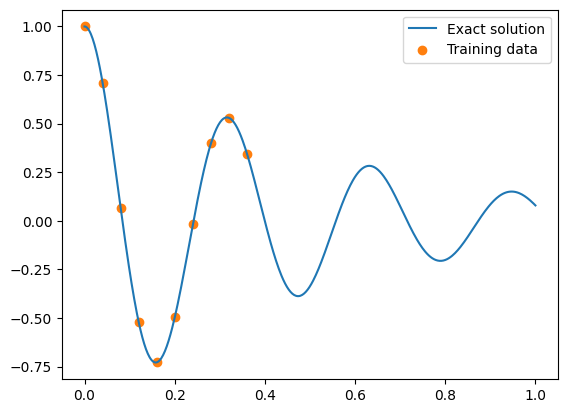

In [4]:
d, w0 = 2, 20

# get the analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

This step is crucial in developing a robust PINN. By limiting the available training data and relying on the differential equation to inform the learning process, we push the model toward true generalization, ensuring that it does not just interpolate between known values but rather understands the fundamental physics governing the motion. With our dataset ready and visualized, the next step involves defining a loss function that integrates both the available data and the physics constraints, setting the stage for training our neural network.

In [5]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4,
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")


Step 5: Training a Standard Neural Network to Fit the Oscillations
Before introducing the Physics-Informed Neural Network (PINN) approach, we first train a standard neural network purely on data, without incorporating any knowledge of the underlying physics. This serves as a baseline, allowing us to see how well a typical deep learning model can approximate the oscillatory motion using only the limited training data we provided earlier.

To achieve this, we follow a structured approach:

(1) Initializing the Neural Network and Optimizer
We begin by setting a random seed (torch.manual_seed(123)) to ensure reproducibility—this makes sure that every time we run the code, we get the same results. Next, we initialize our fully connected neural network (FCN) with the following specifications:

1 input neuron (representing time x),
1 output neuron (representing the oscillator’s position y),
32 hidden units per layer, and
3 hidden layers with Tanh activation functions to model complex patterns.
For optimization, we use the Adam optimizer with a learning rate of 1e-3. Adam is well-suited for training deep networks since it adjusts the learning rate dynamically for each parameter, helping to avoid local minima and speeding up convergence.

(2) The Training Loop
The model is trained over 1,000 iterations (epochs), where we iteratively update its parameters to minimize the difference between predictions and actual training data. Here’s how the loop operates:

At the start of each iteration, we clear previous gradients (optimizer.zero_grad()) to prevent accumulation.
The model takes in the training input data (x_data) and generates predictions (yh = model(x_data)).
The loss function, Mean Squared Error (MSE) (loss = torch.mean((yh - y_data) ** 2)), is computed to measure how far the predictions deviate from the ground truth training data.
Backpropagation is performed (loss.backward()), computing gradients that indicate how much each parameter should be adjusted.
The optimizer updates the model’s weights (optimizer.step()) based on these gradients, refining its predictions.
(3) Visualizing the Training Progress
To monitor the learning process, we plot the results every 10 iterations:

The trained model makes predictions across the entire time domain (yh = model(x).detach()), not just on the training points, to check how well it generalizes.
We call the plot_result() function to overlay the exact analytical solution with the model’s predictions.
Every 500 iterations, the plot is displayed (plt.show()) so we can visually inspect the learning progress. At other iterations, it is closed (plt.close("all")) to keep the output clean.
Why is This Step Important?
At this stage, our neural network is solely relying on data to approximate the harmonic oscillator. However, since it does not incorporate any information about the physical laws governing the system, its predictions may lack generalization and accuracy, especially in regions where we have no training data.

This is where Physics-Informed Neural Networks (PINNs) come into play. Instead of training purely on data, PINNs embed physics equations directly into the learning process, ensuring that the model adheres to the fundamental laws of motion. This makes them far more robust, particularly when dealing with limited or noisy data.

In the next step, we introduce the PINN approach and modify our training strategy to incorporate the governing differential equations of the harmonic oscillator.

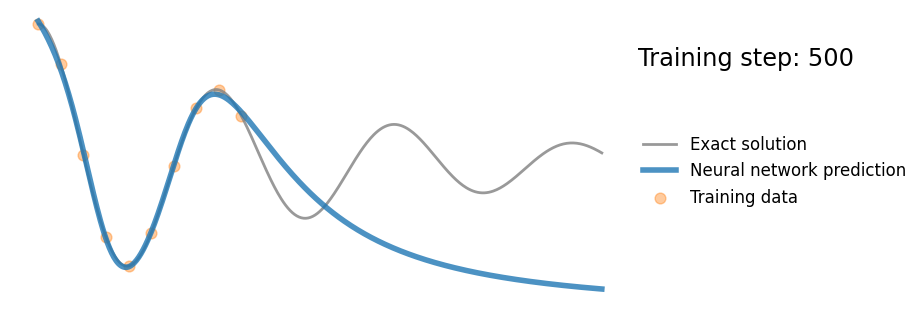

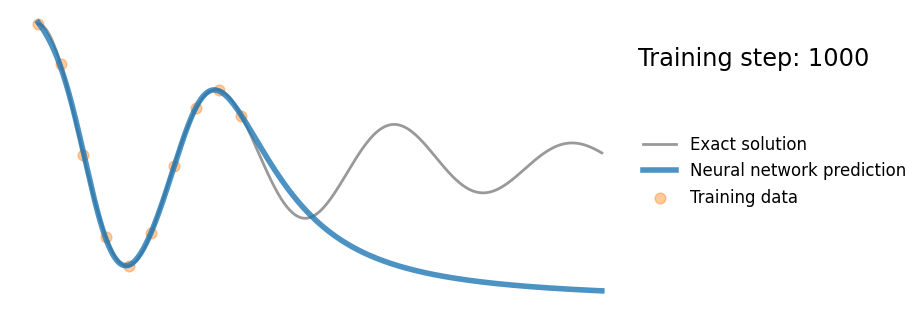

In [ ]:
import os

# train standard neural network to fit training data
torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
for i in range(1000):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()


    # plot the result as training progresses
    if (i+1) % 10 == 0:

        yh = model(x).detach()

        plot_result(x,y,x_data,y_data,yh)

        if (i+1) % 500 == 0: plt.show()

        else: plt.close("all")



At this point, we've seen how a standard neural network attempts to approximate the oscillatory motion purely from data. However, that approach has a fundamental limitation: it does not incorporate the governing physics of the system. This can lead to poor generalization, especially in regions where we have no training data.

Now, we take a major step forward by training a Physics-Informed Neural Network (PINN)—a model that combines data-driven learning with physical laws encoded as differential equations. This allows the model to adhere to the fundamental equations of motion, making it far more robust and accurate. We see that the Output of the model donnot not conform to the path of motion for the SHM.

**bold text**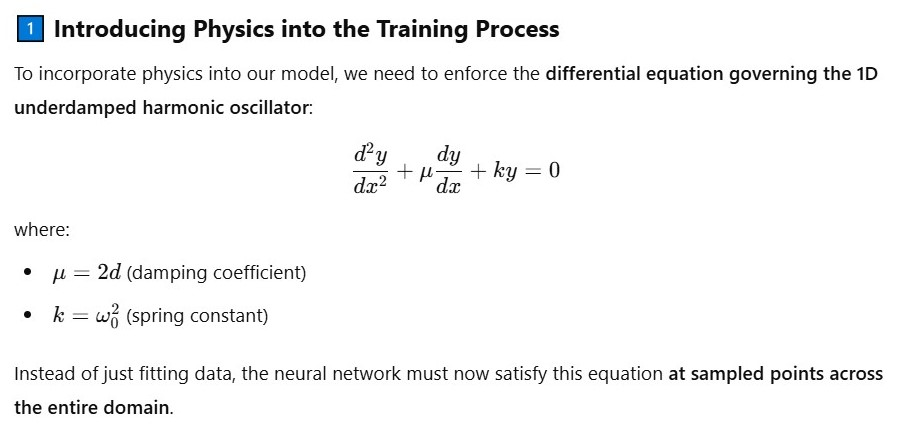

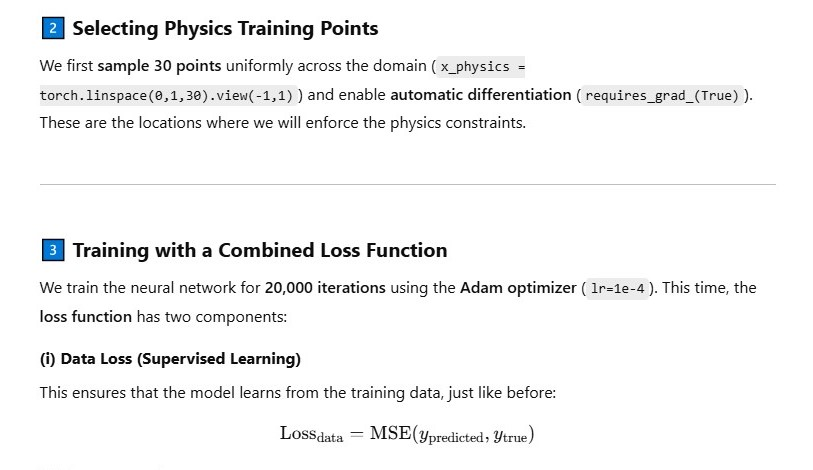

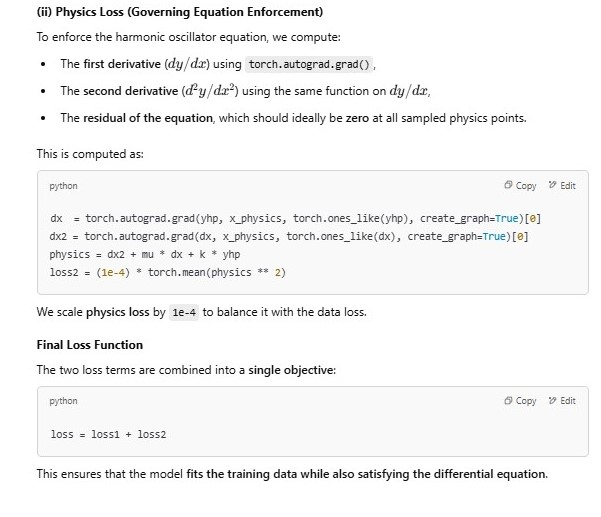

4️⃣ Training Loop and Visualization
During training, we periodically:

Generate predictions over the full domain (yh = model(x).detach()),
Visualize the results using plot_result(), overlaying:
The exact analytical solution,
The neural network’s prediction,
The physics training locations (x_physics), which should help guide the model towards the true solution.
Every 6,000 iterations, we display the plot (plt.show()). At other intervals, the plot is updated without display (plt.close("all")) to keep training efficient.

Why is This Approach Powerful?
Unlike the earlier purely data-driven approach, our Physics-Informed Neural Network (PINN) learns not just from data but also from fundamental laws of motion. This has significant advantages:

1. Better Generalization – Even in regions with no data, the model makes accurate predictions because it obeys the physical equations.
2.  More Robustness – Noisy or incomplete data doesn’t mislead the model, since the physics constraints keep it grounded.
3. Data Efficiency – We need far fewer training points, as the physics itself guides the learning process.

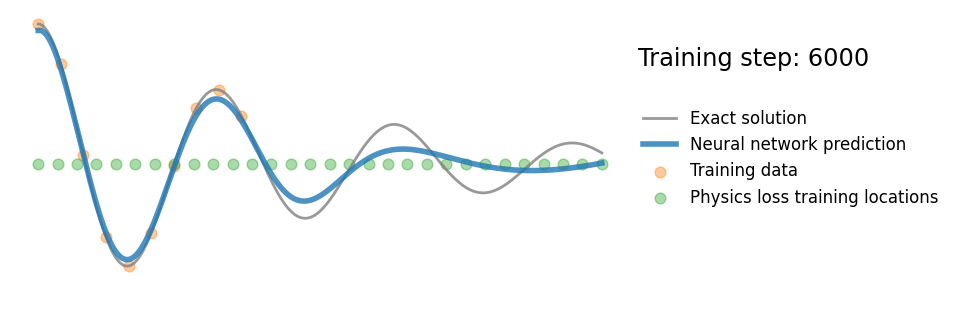

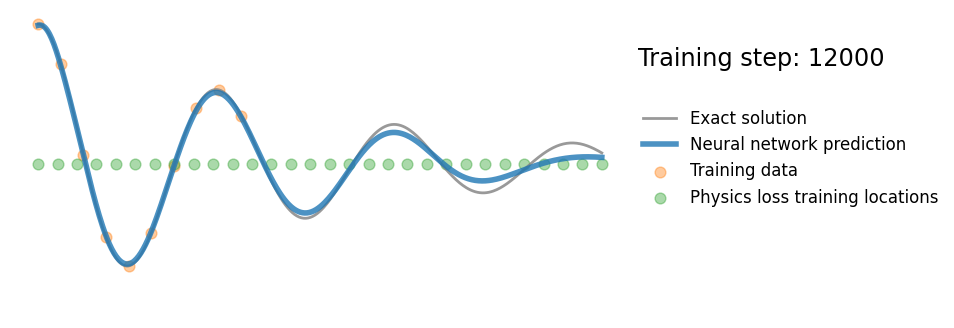

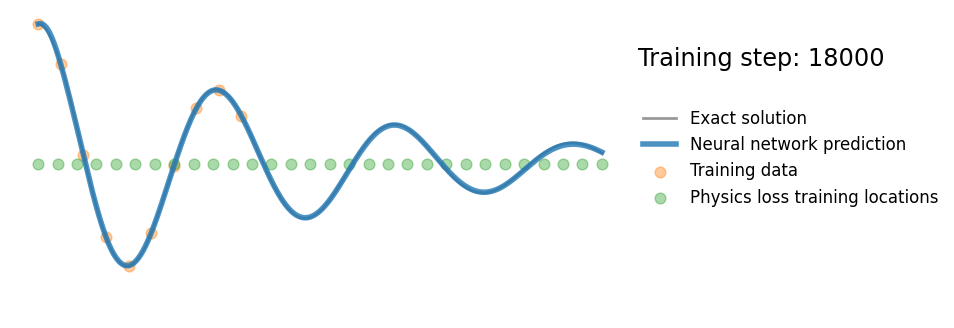

In [ ]:
x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)# sample locations over the problem domain
mu, k = 2*d, w0**2

torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
files = []
for i in range(20000):
    optimizer.zero_grad()

    # compute the "data loss"
    yh = model(x_data)
    loss1 = torch.mean((yh-y_data)**2)# use mean squared error

    # compute the "physics loss"
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + mu*dx + k*yhp# computes the residual of the 1D harmonic oscillator differential equation
    loss2 = (1e-4)*torch.mean(physics**2)

    # backpropagate joint loss
    loss = loss1 + loss2# add two loss terms together
    loss.backward()
    optimizer.step()


    # plot the result as training progresses
    if (i+1) % 150 == 0:

        yh = model(x).detach()
        xp = x_physics.detach()

        plot_result(x,y,x_data,y_data,yh,xp)



        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")



### Conclusion
From the visual results, it is evident that the Physics-Informed Neural Network (PINN) significantly outperforms the ordinary neural network in fitting the oscillatory motion. While the standard neural network relied solely on the training data and struggled to generalize across the entire domain, the PINN leveraged both data and the governing differential equation. This allowed it to better capture the true solution, even in regions where no data was provided. The physics loss constraint helped enforce smoothness and adherence to the expected behavior, making the PINN a superior approach for modeling physical systems.
This completes our journey from a standard neural network to a Physics-Informed Neural Network, demonstrating how deep learning can be enhanced using scientific principles.